In [1]:
%matplotlib inline

from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

from dask.distributed import Client

sns.set(context='talk', palette='colorblind', style='ticks')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:54581 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 81.05 GB


In [3]:
#ds = xr.open_mfdataset('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-07-*.nc')
ds = xr.open_dataset('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-07-01-00000.nc', chunks={'time': 1})

ds = ds.sel(lat=slice(-20,20))

# Separate out GW flux vars and convert Pa -> mPa
gwx = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUX' in var}) * 1000
gwy = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUY' in var}) * 1000

In [4]:
tau = xr.Dataset({i : xu.sqrt(xu.square(gwx[x]) + xu.square(gwy[y])) for (i, (x,y)) in enumerate(zip(gwx.data_vars, gwy.data_vars))})

In [6]:
mx = 0
for (i, x) in enumerate(tau.data_vars):
    if tau[i].max().values > mx:
        mx = tau[i].max().values
        
mx

array(98.59431457519531, dtype=float32)

In [9]:
bins = np.linspace(0, mx, 21)
hist = 0

for (i, x) in enumerate(tau.data_vars):
    (h, edges) = np.histogram(tau[i], bins=bins)
    hist += h

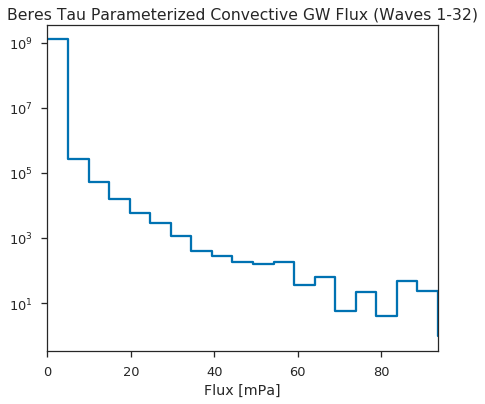

In [13]:
f, ax = plt.subplots(figsize=(7, 6))
ax.step(edges[:-1], hist, where='post')
ax.semilogy()
ax.set_xlim(0, edges[-2])

ax.set_title('Beres Tau Parameterized Convective GW Flux (Waves 1-32)')
ax.set_xlabel('Flux [mPa]')

f.savefig('../figures/waves/dist_flux.png')